In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from gpt_mini.model import GPT
from gpt_mini.trainer import Trainer
from gpt_mini.bpe import MidiDataset
import matplotlib.pyplot as plt
import torch
from gpt_mini.config import DEFAULT_DEVICE, CONFIG
import pickle
from pathlib import Path
import numpy as np

In [3]:
model_config = GPT.get_default_config()
# either model_type or (n_layer, n_head, n_embd) must be given in the config
model_config.model_type = None # 'gpt-nano'
model_config.n_layer = CONFIG["model"]["n_layer"]
model_config.n_head = CONFIG["model"]["n_head"]
model_config.n_embd = CONFIG["model"]["n_embed"]
# model_config.vocab_size = 50257 # 65535        # max number of vocabulary
model_config.vocab_size = CONFIG["model"]["vocab_size"]
# model_config.block_size = 256                  # input context length
model_config.block_size = CONFIG["model"]["block_size"]

model = GPT(model_config)

number of parameters: 12.37M


In [4]:
train_dataset = MidiDataset(
    CONFIG["preprocess"]["data_train"],
    CONFIG["tokenizer"]["model"],
    CONFIG["model"]["block_size"])
print(train_dataset)

In [5]:
# your subclass of torch.utils.data.Dataset that emits example
# torch LongTensor of lengths up to 1024, with integers from [0,50257)
train_config = Trainer.get_default_config()
train_config.learning_rate = CONFIG["training"]["learning_rate"]
train_config.max_iters = CONFIG["training"]["max_iters"]
train_config.batch_size = CONFIG["training"]["batch_size"]
train_config.num_workers = CONFIG["training"]["workers"]
train_config.device = DEFAULT_DEVICE
trainer = Trainer(train_config, model, train_dataset)

running on device mps


In [6]:
tokenizer = None
f = open(CONFIG["tokenizer"]["model"], 'rb')
tokenizer = pickle.load(f)
f.flush()
f.close()

In [7]:
test_files = []
with open(CONFIG["preprocess"]["data_test"], "r", encoding="utf-8") as f:
    test_files = f.readlines()

encoded_test_set = []
for test_input in test_files:
    tokens = tokenizer.encode(f"{Path.cwd()}/{str.rstrip(test_input)}")
    encoded_test_set.append(tokens[0].ids)

f = open("test_set.pkl", 'wb')
pickle.dump(encoded_test_set, f)
f.flush()
f.close()

f = open("test_set.pkl", 'rb')
encoded_test_set = pickle.load(f)
f.close()

len(encoded_test_set)
print(encoded_test_set[0])


[283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 524, 559, 208, 8927, 1036, 213, 1497, 38392, 7062, 47462, 216, 7062, 38618, 7062, 38681, 219, 7062, 220, 12633, 48371, 190, 2064, 2064, 191, 1497, 192, 1497, 193, 12633, 194, 7062, 37065, 196, 7062, 12368, 197, 12368, 736, 559, 38396, 27989, 38764, 38818, 4761, 17564, 190, 4761, 965, 191, 4761, 36866, 193, 4761, 965, 194, 965, 195, 902, 196, 902, 902, 45645, 14184, 965, 18525, 200, 4761, 15039, 4761, 202, 10901, 203, 10901, 1450, 1213, 20787, 31181, 755, 27462, 206, 5021, 31732, 11244, 46844, 216, 1290, 218, 4154, 16399, 45879, 201, 14710, 4761, 31773, 38127, 283, 48822, 40832, 902, 8454, 965, 202, 41510, 4761, 18611, 4761, 205, 29487, 4761, 965, 207, 4761, 37926, 15137, 902, 210, 15679, 965, 47233, 965, 213, 965, 27808, 4761, 14360, 216, 4761, 217, 10901, 10901, 4751, 1092, 4099, 10342, 560, 8716, 12207, 46330, 5871, 210, 2064, 3672, 758, 4080, 772, 9426, 40260, 7718, 198, 2064, 560, 461, 5405, 5082, 4901, 38318, 4

In [ ]:
loss_values = []
accuracy_values = []

def calculate_note_accuracy(predicted_notes, actual_notes):
    correct_predictions = 0
    total_predictions = len(actual_notes)

    for predicted, actual in zip(predicted_notes, actual_notes):
        if predicted == actual:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy


def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")

        correct_predictions = 0
        total_predictions = 0

        model.eval()

        # for test_input, test_target in test_files:
        # for test_input in test_files:
        for tokens in encoded_test_set:
            # load the test midi
            # tokens = tokenizer.encode(f"{Path.cwd()}/{str.rstrip(test_input)}")
            # get the bpe ids
            # tokens = tokens[0].ids

            # make it into a tensor
            x = torch.tensor(tokens, dtype=torch.long, device=DEFAULT_DEVICE)
            x = x.expand(5, -1)
            # run it though the model
            y = model.generate(x, max_new_tokens=32, do_sample=True, top_k=40)

            # Forward pass
            # output = model(test_input)
            # Compute accuracy
            output = y
            predicted_notes = output.argmax(dim=-1)
            actual_notes = x.argmax(dim=-1)
            correct_predictions += (np.array(predicted_notes.cpu()) == np.array(actual_notes.cpu())).sum().item()
            total_predictions += output.numel()
            # total_predictions += calculate_note_accuracy(predicted_notes, actual_notes)

        accuracy = correct_predictions / total_predictions
        accuracy_values.append(accuracy)
        # accuracy_values.append(total_predictions)
        loss_values.append(trainer.loss.item())

        # Save checkpoints
        torch.save(
            trainer.model.state_dict(),
            f"./checkpoints/gpt_{trainer.iter_num}.pt")

        model.train()

trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()

/Users/robrohan/miniconda3/envs/comp838/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used

iter_dt 0.00ms; iter 0: train loss 10.83640


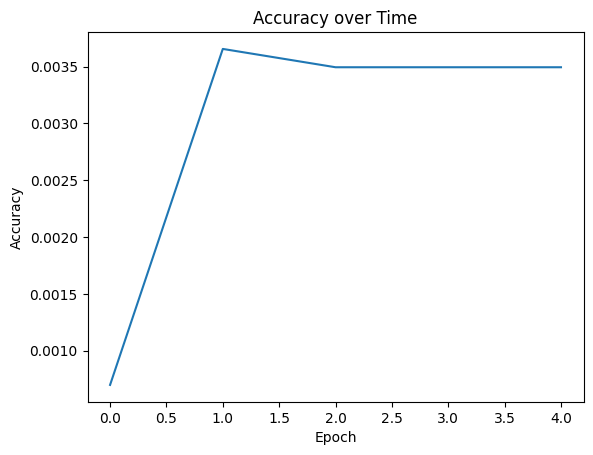

In [ ]:
# Plot the accuracy graph
plt.plot(accuracy_values)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Time')
plt.show()

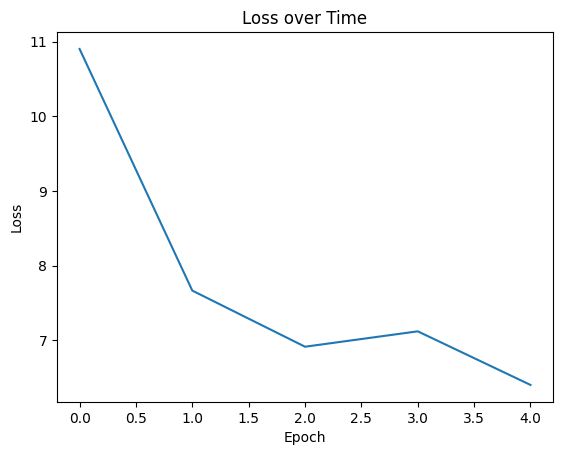

In [ ]:
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.show()